In [1]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import numpy as np
import xarray as xr
import downscale as down

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite','IMERG','IMERG_Italy_1dy_2000_06_01_2024_02_29_veneto_R2.nc')
DATA = xr.open_dataset(data_dir)
DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(2001,2010+1)]))

lons = DATA.lon.values
lats = DATA.lat.values

lon2d_ref, lat2d_ref = np.meshgrid(lons, lats)

nlon_ref = np.size(lons)
nlat_ref = np.size(lats)

dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])

ntime = len(DATA['time'])

DATA

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 3652, lat: 10, lon: 10)
Coordinates:
  * time     (time) datetime64[ns] 29kB 2001-01-01 2001-01-02 ... 2010-12-31
  * lat      (lat) float64 80B 45.55 45.65 45.75 45.85 ... 46.25 46.35 46.45
  * lon      (lon) float32 40B 12.05 12.15 12.25 12.35 ... 12.75 12.85 12.95
Data variables:
    PRE      (time, lat, lon) float64 3MB ...
Attributes:
    description:  IMERG daily data for Italy region

In [146]:
lon2 = np.arange(np.round(np.sort(lons)[0]+dx/2,2),np.round(np.sort(lons)[-2]+dx/2,2), dx/2)
lat2 = np.arange(np.round(np.sort(lats)[0]+dy/2,2),np.round(np.sort(lats)[-2]+dy/2,2), dy/2)
lon2d2, lat2d2 = np.meshgrid(lon2, lat2)

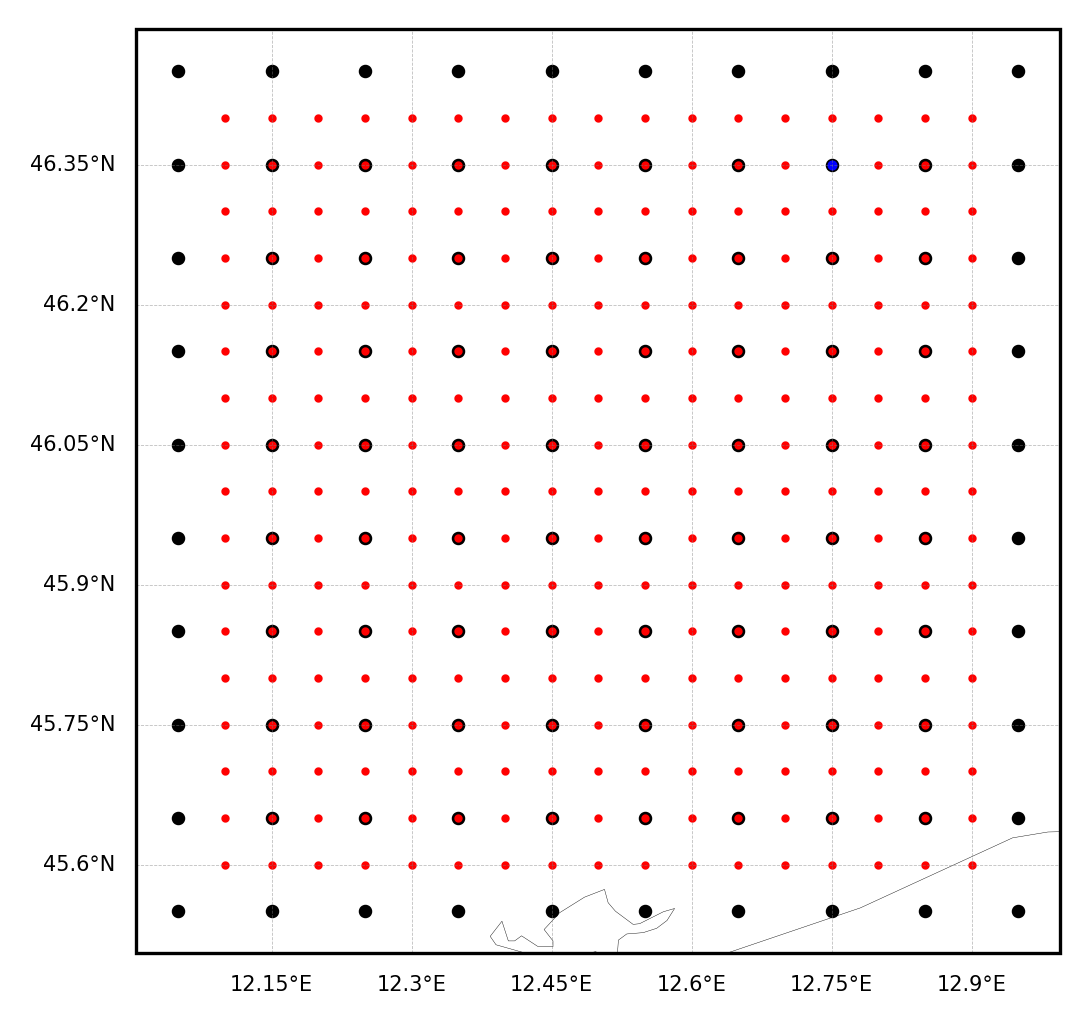

In [147]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,4),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
# ax1.set_extent([12, 13, 45.5, 46.5], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')

# a1 = ax1.contourf(lon2d_ref, lat2d_ref, np.mean(DATA['PRE'].values,axis=0), cmap=cmap)

ax1.scatter(lon2d_ref, lat2d_ref, s=5, c='k')
ax1.scatter(lon2d2, lat2d2, s=1, c='r')
ax1.scatter(12.75, 46.35, s=2, c='b')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.033)
cbar.ax.tick_params(labelsize=5)

In [63]:
thresh = 1
acf = 'mar'
toll=0.005
opt_method='genetic'
Tr = np.array([1, 2, 5, 10, 20, 50, 100])
nyears = len(Tr)

In [82]:
clat, clon = 46.35, 12.75
L1 = down.area_lat_long(clat, clon, dy, dx)[0] # in Km
L0 = down.area_lat_long(clat, clon, 0.005, 0.005)[0] # in Km
print(f'Pixel area L1: {L1} km**2')
print(f'Pixel area L0: {L0} km**2')

Pixel area L1: 9.242421782464504 km**2
Pixel area L0: 0.4619218506990531 km**2


In [83]:
tmpalat = DATA['lat'][:]
tmpalon = DATA['lon'][:]
dates = DATA['time'][:]
dset = np.swapaxes(DATA['PRE'],0,2).data[:,:,:]
xrs0 = xr.DataArray(dset,  coords={'lon':tmpalon, 'lat':tmpalat, 'time':dates},
                                                    dims=('lon', 'lat', 'time'))
xrs = xrs0.where(xrs0 >= -0.001)

In [104]:
npix = 3
buffer = 0.50*npix*dx

eps = 1e-2 # to make sure to include boundaires -> add an eps buffer

solat = clat - buffer + eps
nolat = clat + buffer + eps
ealon = clon + buffer + eps
welon = clon - buffer + eps
bcond = np.logical_and(
            np.logical_and( xrs.lat > solat, xrs.lat < nolat),
            np.logical_and( xrs.lon > welon, xrs.lon < ealon))

box_3h = xrs.where(bcond, drop = True).load()

In [100]:
downres = down.downscale(box_3h, Tr, thresh=thresh, L0=0.001, dt=24,
                            toll=toll, tscale=24,
                            acf=acf, save_yearly=False,
                            maxmiss=100, clat=clat, clon=clon,
                            opt_method=opt_method, plot=True)

Downscaling Intermittency
Taylor_Beta WARNING: not enough accuracy!
the time resolution of the coarse data might not be enough!
or try to increase the value of interp
Downscaling the correlation
Computing the correlation
differential_evolution step 1: f(x)= 0.0003195311860070531
differential_evolution step 2: f(x)= 0.0003195311860070531
differential_evolution step 3: f(x)= 0.00026658169280701185
Polishing solution with 'L-BFGS-B'
integration domain is zero
Downscaling pdf - global Weibull parameters
Downscaling pdf - yearly Weibull parameters


In [101]:
downres

{'Tr': array([  1,   2,   5,  10,  20,  50, 100]),
 'mev_d': array([  1.08753394,  80.90028985, 113.08883175, 136.6725359 ,
        161.03047113, 195.14089753, 222.6490046 ]),
 'mev_s': array([  1.08984227,  78.47602785, 108.42828299, 130.11567193,
        152.34128157, 183.23016048, 207.97733347]),
 'gam_d': 0.9706371847550544,
 'gam_s': 0.9771974083021765,
 'beta': 0.9300127078272534,
 'Nd': 156.0,
 'Cd': 4.823699694959382,
 'Wd': 0.6011540555761813,
 'Ns': 145,
 'Cs': 5.546771961584439,
 'Ws': 0.6348598517592213,
 'eps_s': 201.89208312975046,
 'alp_s': 0.968995860084439,
 'eps_d': 86.91842263208382,
 'alp_d': 0.5394080910166936,
 'corr_down_success': True,
 'corr_down_funval': 0.00026559318966272243,
 'w_down_funval': 3.552713678800501e-15,
 'thresh': 1,
 'clat': 46.35000000000001,
 'clon': 12.75,
 'corr_plot': <Figure size 640x480 with 1 Axes>,
 'Taylor_contour': <Figure size 640x480 with 2 Axes>}

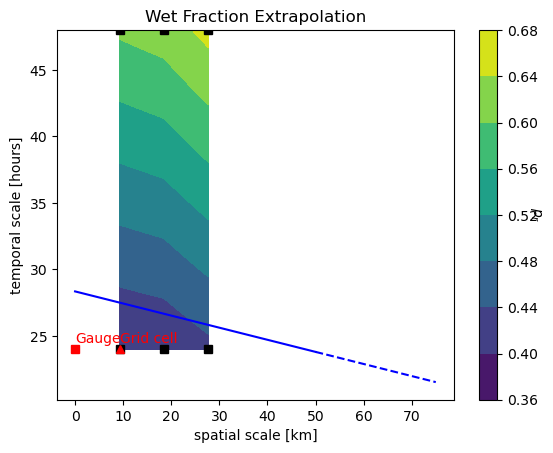

In [102]:
downres['Taylor_contour']

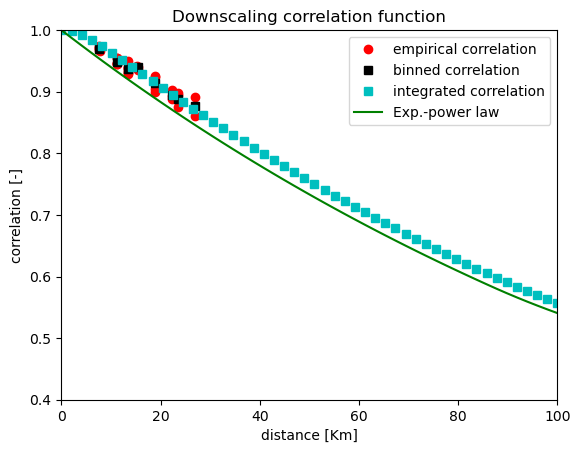

In [103]:
downres['corr_plot']

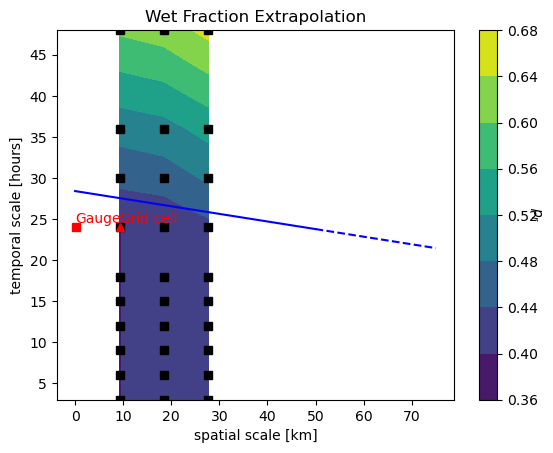

In [33]:
downres['Taylor_contour']